In [1]:

import sys
import os
print (sys.path[6])
print (sys.version)


/anaconda/envs/py35/lib/python3.5/plat-linux
3.5.5 |Anaconda custom (64-bit)| (default, May 13 2018, 21:12:35) 
[GCC 7.2.0]


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from abc import ABC, abstractmethod
import torchvision.datasets as dset
import pretrainedmodels
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Subset

%load_ext autoreload
%autoreload 2
from utils import featuresDataset
import utils
import pickle
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dataset = 'cifar10'
train_batch_size=128
prefetch=2
test_batch_size=128
data_path='../datasets/cifar10_data'
dataloaders={}

train_size=50000
test_size=10000

train_indices=list(range(train_size))
test_indices=list(range(test_size))

In [4]:
#loading the datasets and generating the data loaders for images



image_datasets = {x: dset.CIFAR10(data_path, train=(x=='train'), transform=data_transforms[x], download=True)
                  for x in ['train', 'val']}
nlabels = len(image_datasets['train'].classes)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}



Files already downloaded and verified
Files already downloaded and verified


In [6]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=train_batch_size,
                                                   shuffle=False,
                                                   num_workers=prefetch, pin_memory=True)
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=test_batch_size,
                                                  shuffle=False,
                                                    num_workers=prefetch, pin_memory=True)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names =image_datasets['train'].classes

In [8]:
#Generating the features 

#lets create a model up to the last layer
model= pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')
model_ft = torch.nn.Sequential(*list(model.children())[:-1])

In [10]:
def get_images_features(model, dataset=None, batch_size=None, max_images=None,data_dir='Data_features',data_type='train',basefilename='Features_data'):
    filepath=os.path.join(data_dir,"{}_{}.pickle".format(data_type,basefilename))
    if os.path.exists(filepath):
        print('Found a saved copy of cifar 10 SENRexnext50 features, loading...',end="")
        with open(filepath, 'rb') as f:
            images_features_numpy,images_labels_numpy=pickle.load(f)
        print("Done")
        return images_features_numpy,images_labels_numpy
        
    
    print('Saved data not found, computing...')
    model.eval()
    model = model.cuda()

    all_images_features = []
    all_images_labels = []
    
    print("Loading and generating images feature vectors...")
    for images, labels in torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=1,batch_size=batch_size):
        with torch.no_grad():
            images = images.cuda()
            features = model(images).squeeze().cpu()
            all_images_features.append(features)
            all_images_labels.append(labels)
#             print(labels)
        batch_processed = len(all_images_features)
        if max_images and (batch_processed* batch_size)+ batch_size > max_images:
            print("Done)")
            break
        print('batch {}/{}'.format(len(all_images_features),len(dataset)//128),end='\r')
    print("Finished generating feature vectors. Now concatenating...",end="")

    images_features_numpy = torch.cat(all_images_features, 0).numpy()
    images_labels_numpy = torch.cat(all_images_labels, 0).numpy()
    print("Done")
    
    if not os.path.exists(data_dir):
        print('folder not found, craeting...Done')
        os.makedirs(data_dir)
        
    with open(filepath, 'wb') as f:
        print('Saving the features to file...', end="")
        pickle.dump((images_features_numpy,images_labels_numpy), f)
        print("Done")
      
    return images_features_numpy,images_labels_numpy

In [11]:
#Saving the features for the validation set

val_images_features,val_images_labels=get_images_features(model_ft, dataset=image_datasets['val'], batch_size=128, max_images=None,data_type='val',data_dir='../datasets/cifar10_image_features',basefilename='Features_data')
train_images_features,train_images_labels=get_images_features(model_ft, dataset=image_datasets['train'], batch_size=128, max_images=None,data_type='train',data_dir='../datasets/cifar10_image_features',basefilename='Features_data')

Saved data not found, computing...
Loading and generating images feature vectors...
Finished generating feature vectors. Now concatenating...Done
folder not found, craeting...Done
Saving the features to file...Done
Saved data not found, computing...
Loading and generating images feature vectors...
Finished generating feature vectors. Now concatenating...Done
Saving the features to file...Done


In [12]:
ft_datasets={'train':featuresDataset(train_images_features,train_images_labels),'val':featuresDataset(val_images_features,val_images_labels)}
ft_dataloaders = {x: torch.utils.data.DataLoader(ft_datasets[x], batch_size=128,shuffle=False, num_workers=1)
              for x in ['train','val']}


In [16]:
ft_dataset_sizes = {'train':train_size, 'val':test_size}
ft_class_names = class_names
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
imgagenet_classes=[val for key,val in utils.imagenetClasses.items()]

In [51]:
#Creating a classifer model over the embedings
import torch
import torch.nn as nn
import torch.nn.functional as F


# ft_model=nn.Sequential(
#     nn.Linear(2048, 256),
#     nn.ReLU(),
#     nn.Linear(256, 10), 
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
# )

ft_model=nn.Linear(2048, 10)

print(ft_model)
ft_model=ft_model.to(device)

Linear(in_features=2048, out_features=10, bias=True)


In [24]:
def train_ft_model(model, dataloaders,criterion, optimizer, num_epochs=25):
    since = time.time()
    dataset_sizes={x:len(dataloaders[x])*dataloaders[x].batch_size for x in ['train','val']}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epochStart = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            minibatch_cnt=0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                minibatch_cnt+=1
                print("Progress {:2.1%}".format(minibatch_cnt / len(dataloaders[phase])), end="\r")
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            time_elapsed = time.time() - epochStart
            print('Epoch complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [52]:

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(ft_model.parameters(), lr=0.001, momentum=0.9)


ftmodel = train_ft_model(ft_model,ft_dataloaders, criterion, optimizer_ft,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.5813 Acc: 0.8338
Epoch complete in 0m 1s
val Loss: 0.3858 Acc: 0.8666
Epoch complete in 0m 1s

Epoch 1/99
----------
train Loss: 0.3522 Acc: 0.8854
Epoch complete in 0m 1s
val Loss: 0.3444 Acc: 0.8768
Epoch complete in 0m 1s

Epoch 2/99
----------
train Loss: 0.3200 Acc: 0.8936
Epoch complete in 0m 1s
val Loss: 0.3258 Acc: 0.8815
Epoch complete in 0m 1s

Epoch 3/99
----------
train Loss: 0.3016 Acc: 0.8999
Epoch complete in 0m 1s
val Loss: 0.3145 Acc: 0.8850
Epoch complete in 0m 1s

Epoch 4/99
----------
train Loss: 0.2889 Acc: 0.9034
Epoch complete in 0m 1s
val Loss: 0.3067 Acc: 0.8883
Epoch complete in 0m 1s

Epoch 5/99
----------
train Loss: 0.2791 Acc: 0.9062
Epoch complete in 0m 1s
val Loss: 0.3007 Acc: 0.8899
Epoch complete in 0m 1s

Epoch 6/99
----------
train Loss: 0.2712 Acc: 0.9091
Epoch complete in 0m 1s
val Loss: 0.2961 Acc: 0.8905
Epoch complete in 0m 1s

Epoch 7/99
----------
train Loss: 0.2645 Acc: 0.9113
Epoch complete in 0m 1s
val Lo

train Loss: 0.1724 Acc: 0.9433
Epoch complete in 0m 1s
val Loss: 0.2619 Acc: 0.9010
Epoch complete in 0m 1s

Epoch 63/99
----------
train Loss: 0.1717 Acc: 0.9435
Epoch complete in 0m 1s
val Loss: 0.2619 Acc: 0.9009
Epoch complete in 0m 1s

Epoch 64/99
----------
train Loss: 0.1711 Acc: 0.9438
Epoch complete in 0m 1s
val Loss: 0.2619 Acc: 0.9011
Epoch complete in 0m 1s

Epoch 65/99
----------
train Loss: 0.1704 Acc: 0.9439
Epoch complete in 0m 1s
val Loss: 0.2619 Acc: 0.9010
Epoch complete in 0m 1s

Epoch 66/99
----------
train Loss: 0.1698 Acc: 0.9443
Epoch complete in 0m 1s
val Loss: 0.2619 Acc: 0.9011
Epoch complete in 0m 1s

Epoch 67/99
----------
train Loss: 0.1692 Acc: 0.9445
Epoch complete in 0m 1s
val Loss: 0.2619 Acc: 0.9014
Epoch complete in 0m 1s

Epoch 68/99
----------
train Loss: 0.1685 Acc: 0.9448
Epoch complete in 0m 1s
val Loss: 0.2619 Acc: 0.9012
Epoch complete in 0m 1s

Epoch 69/99
----------
train Loss: 0.1679 Acc: 0.9449
Epoch complete in 0m 1s
val Loss: 0.2619 Acc:

In [23]:
model_parameters = filter(lambda p: p.requires_grad, ft_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

527114


# attaching the classifer to the base
This should result in the same results as the trained classifier.

In [26]:
full_model=pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')
full_model.last_linear=ft_model
full_model.cuda()
# print(full_model)

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
     

In [46]:
import math

def visualize_model(model, num_images=6,useImagenetClasses=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(math.ceil(num_images/4),4, figsize=(16, 10.5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =0.5, wspace=.3)
    axs = axs.ravel()
    
    imgCnt=0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):

#                 ax = axs[imgCnt+j]
#                 ax.axis('off')
                if useImagenetClasses:
                    axs[imgCnt+j].set_title(j)
                    axs[imgCnt+j].set_title('pr:{} \n lb:{}'.format(imgagenet_classes[preds[j]],class_names[labels[j]]))
                else:
                    axs[imgCnt+j].set_title('pr:{} \n lb:{}'.format(class_names[preds[j]],class_names[labels[j]]))
                images_so_far += 1   
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                axs[imgCnt+j].imshow(inp)
#                 imshow(inputs.cpu().data[j],ax=axs[imgCnt+j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            imgCnt+=inputs.size()[0]
        model.train(mode=was_training)

def eval_model(model, dataloaders):
    since = time.time()
    dataset_sizes={x:len(dataloaders[x])*dataloaders[x].batch_size for x in ['train','val']}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    phase='val'
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    minibatch_cnt=0
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        minibatch_cnt+=1
        print("Progress {:2.1%}".format(minibatch_cnt / len(dataloaders[phase])), end="\r")


        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)


            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        val_loss = running_loss / dataset_sizes[phase]
        val_acc = running_corrects.double() / dataset_sizes[phase]
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, val_loss, val_acc))

    return 


val Loss: 0.2696 Acc: 0.9010


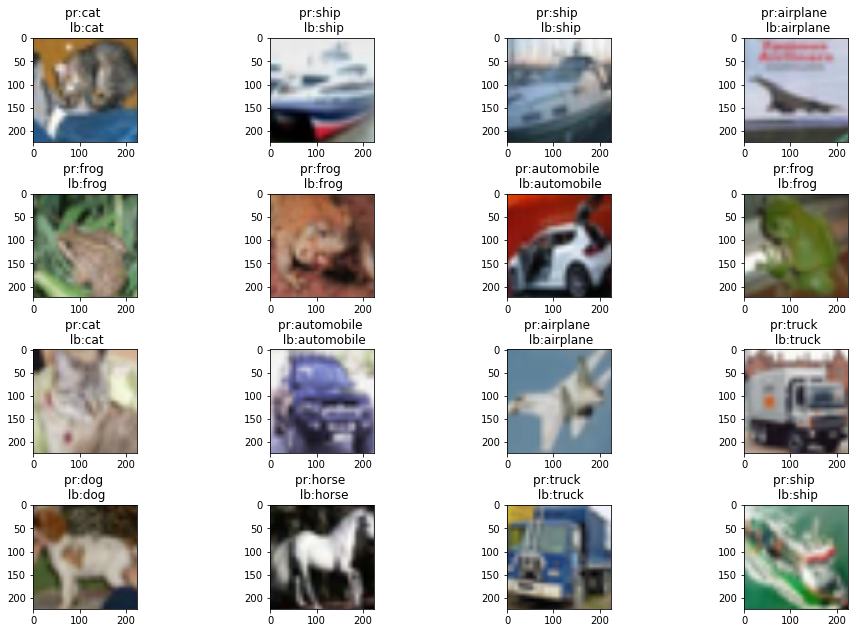

In [47]:
eval_model(full_model, dataloaders)
visualize_model(full_model,num_images=16,useImagenetClasses=False)

In [43]:
import math

def visualize_on_features(num_images=6):
    ftmodel.eval()
    images_so_far = 0
    fig, axs = plt.subplots(math.ceil(num_images/4),4, figsize=(16, 10.5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =0.5, wspace=.3)
    axs = axs.ravel()
    
    imgCnt=0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            features,_=next(iter(ft_dataloaders['val']))
            features=features.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = ftmodel(features)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):

#                 ax = axs[imgCnt+j]
#                 ax.axis('off')
               
                axs[imgCnt+j].set_title('pr:{} \n lb:{}'.format(class_names[preds[j]],class_names[labels[j]]))
                images_so_far += 1   
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                axs[imgCnt+j].imshow(inp)
#                 imshow(inputs.cpu().data[j],ax=axs[imgCnt+j])
                if images_so_far == num_images:
                    return
            imgCnt+=inputs.size()[0]
        


val Loss: 0.2696 Acc: 0.9010


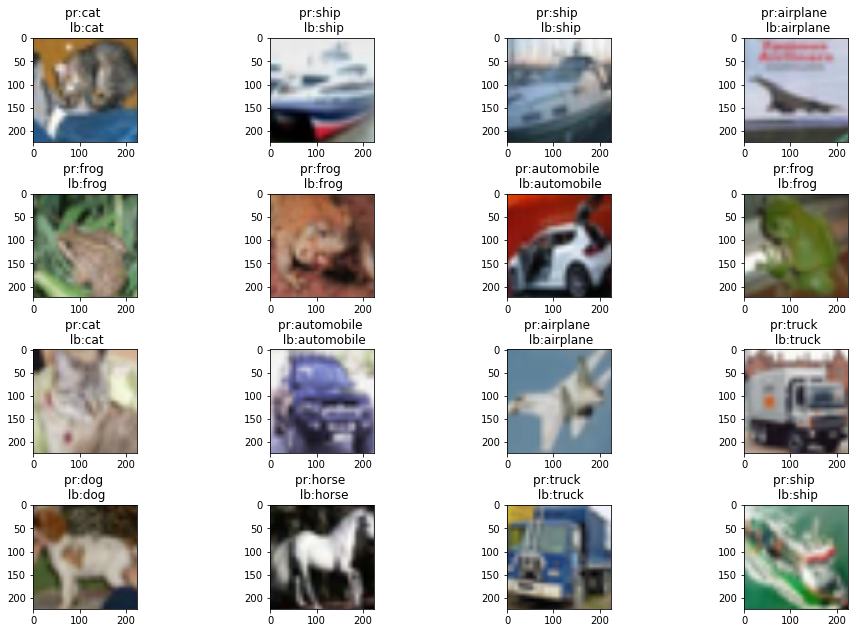

In [45]:
eval_model(ft_model, ft_dataloaders)
visualize_on_features(num_images=16)

# The basic approach: Transfer learning on the images themselves
The issue with this approach is the slow forward path that slows down the training alot. In theory, it should produce the same result as above after 99 epochs.

In [50]:

model = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')

for param in model.parameters():
    param.requires_grad = False

num_ftrs=model.last_linear.in_features
model.last_linear = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, 10), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
# num_ftrs=model.last_linear.in_features
# model.last_linear = nn.Linear(num_ftrs, 10)
model.cuda()


527114


SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
     

In [15]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epochStart = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            minibatch_cnt=0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                minibatch_cnt+=1
                print("Progress {:2.1%}".format(minibatch_cnt / len(dataloaders[phase])), end="\r")
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            time_elapsed = time.time() - epochStart
            print('Epoch complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
# model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


NameError: name 'dataset_sizes' is not defined